# Rooms available for a date range

First let's solve the following query.
> In the hotel database, show all rooms available between **2021-10-05** and **2021-10-10**.

We will use the `shared_hotel` database designed previously:

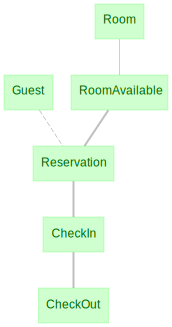

In [4]:
import datajoint as dj
schema = dj.Schema('shared_hotel')
schema.spawn_missing_classes()
dj.Diagram(schema)

First let's find all available unreserved rooms in the date range

In [34]:
start_date = "2021-10-05"
end_date = "2021-10-10" 

available = (RoomAvailable - Reservation) & f'date between "{start_date}" and "{end_date}"'
available

room,date,price
0,2021-10-05,46.00
0,2021-10-06,222.00
0,2021-10-07,348.00
0,2021-10-08,313.00
0,2021-10-09,231.00
0,2021-10-10,278.00
1,2021-10-05,46.00
1,2021-10-06,222.00
1,2021-10-07,348.00
1,2021-10-08,313.00


In [36]:
night_counts = Room.aggr(available, n='count(*)')
night_counts 

room,n calculated attribute
0,6
1,5
2,6
3,4
4,4
5,4
6,4
7,6
8,5
9,4


Now show all the rooms available for all 6 nights.

In [39]:
(night_counts & 'n=6').proj()

room
0
2
7
12
16
23
29
30
33
45


In [42]:
# In SQL, this becomes: 
(night_counts & 'n=6').make_sql()

'SELECT `room`,count(*) as `n` FROM `shared_hotel`.`room` NATURAL JOIN `shared_hotel`.`room_available` WHERE ((`room`,`date`) not in (SELECT `room`,`date` FROM `shared_hotel`.`reservation`))AND(date between "2021-10-05" and "2021-10-10") GROUP BY `room` HAVING (n=6)'

```sql
SELECT `room`, count(*) as `n` 
FROM `shared_hotel`.`room`  NATURAL JOIN `shared_hotel`.`room_available` 
WHERE (`room`,`date`) NOT IN (
    SELECT `room`,`date` 
    FROM `shared_hotel`.`reservation`) AND 
    `date` between "2021-10-05" and "2021-10-10" 
GROUP BY `room` HAVING (n=6)
```

# Relational Division

Relational division is a query of the type: 
> "Find all entries in A that have a mathcing entry in B for each entry in C."

For example, imagine you have a database for managing the hiring pipeline for a company. You have Tables `Employee` and `EmployeeSkill` listing all employees' skills. Then you have a table `Job` and `RequiredSkills`. You are now asked to list all employees that have qualify for a given job. 

This is not a trivial query with no direct support in DataJoint and SQL. There are several ways to solve it. I will illustrate just one. You can search for other articles on relational division to review other approaches.

In [43]:
import datajoint as dj
from faker import Faker

fake = Faker()

In [44]:
schema = dj.Schema('dimitri_hiring')
schema.drop()
schema = dj.Schema('dimitri_hiring')

Proceed to delete entire schema `dimitri_hiring`? [yes, No]: yes


In [45]:
@schema
class Skill(dj.Lookup):
    definition = """
    skill : varchar(24)
    """
    contents = zip(("SQL", "Java", "Python", "C++", "JavaScript", "R", "Rust"))
    

In [46]:
@schema
class Candidate(dj.Manual):
    definition = """
    candidate_id : int
    ---
    name  : varchar(60)
    """
    
    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [47]:
Candidate.insert(((fake.random_int(), fake.name()) for _ in range(300)), 
                 skip_duplicates=True)

In [48]:
Candidate.Skill.insert(
    Candidate.proj() * Skill & 'RAND() < 0.4')

In [49]:
Candidate.Skill()

candidate_id,skill
7,C++
7,Java
7,Python
7,SQL
10,Java
10,Rust
20,JavaScript
20,Python
20,Rust
41,C++


In [50]:
@schema
class Position(dj.Manual):
    definition = """
    position : varchar(12)   
    ---
    position_description : varchar(60)
    """

    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [51]:
Position.insert1(("SWE1", "Software Engineer I"))
Position.Skill.insert((
    ("SWE1", "Rust"),
    ("SWE1", "JavaScript"),
    ("SWE1", "Java")))

In [52]:
Position.insert1(("DS2", "Data Scientist II"))
Position.Skill.insert((
    ("DS2", "SQL"),
    ("DS2", "Python")))

In [53]:
Position.Skill()

position,skill
DS2,Python
DS2,SQL
SWE1,Java
SWE1,JavaScript
SWE1,Rust


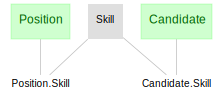

In [54]:
dj.Diagram(schema)

# Query example

In [55]:
# All candidates have the required skill

cpp_experts = Candidate & (Candidate.Skill & {"skill": 'C++'})
cpp_experts

candidate_id,name
7,Mrs. Stephanie Allen DVM
41,Manuel Stokes
64,Angela Robles
74,Margaret Cisneros DDS
102,Miss Abigail Hamilton
204,Sherri Sullivan
232,Christine Morgan
323,Andrea Harris
447,Samantha Gardner
497,Brenda Davis


### Show candidates who qualify for a given job

Rephrase (position)

> Show candidates who have *all* the skills required for job "SWE1"

Rephrasing (a double negative)

> Show candidates for whom there is no skill required for job "SWE1" that she does not possess.


In [48]:
# skills for SWE1
required_skill = Position.Skill() & {'position': "SWE1"}
required_skill

position,skill
SWE1,Java
SWE1,JavaScript
SWE1,Rust


In [49]:
# candidates' missing skills
missing_skill = Candidate.proj() * required_skill - Candidate.Skill
missing_skill

candidate_id,position,skill
0,SWE1,Rust
0,SWE1,JavaScript
0,SWE1,Java
42,SWE1,Rust
42,SWE1,JavaScript
42,SWE1,Java
49,SWE1,Rust
49,SWE1,JavaScript
49,SWE1,Java
70,SWE1,Rust


In [50]:
# qualified candidates
qualified_candidate = Candidate - missing_skill
qualified_candidate

candidate_id,name
722,Tiffany Carpenter
730,Ashley Good
942,Christina Lambert
1036,Martin Rangel
1282,Andrea Young
1680,Derrick Kelley
2508,Yolanda Banks
3031,Karla Lynch
3083,James Phillips
4458,Emily Wallace


In [53]:
# Candidates who qualify for job SWE1

Candidate - (
    (Candidate.proj() * Position.Skill & {'position': "SWE1"})
    - Candidate.Skill)

candidate_id,name
722,Tiffany Carpenter
730,Ashley Good
942,Christina Lambert
1036,Martin Rangel
1282,Andrea Young
1680,Derrick Kelley
2508,Yolanda Banks
3031,Karla Lynch
3083,James Phillips
4458,Emily Wallace


## SQL equlvalent

Literal translation of the above DataJoint query
```sql
USE dimitri_hiring;

SELECT candidate_id, name 
FROM candidate 
WHERE candidate_id NOT IN (
    SELECT candidate_id
    FROM candidate NATURAL JOIN position__skill
    WHERE position = "SWE1" AND (candidate_id, skill) NOT IN (
        SELECT candidate_id, skill FROM candidate__skill))
```

## Using Aggregation

Another method is to simply compare the number of matching skils for each candidate to the total number of matching skills, using aggregation.

In [61]:
qualified = Candidate.aggr(
    Candidate.Skill * Position.Skill & {'position': "SWE1"}, 
    'name', n='count(skill)') & 'n=3'

qualified

candidate_id,name,n calculated attribute
722,Tiffany Carpenter,3
730,Ashley Good,3
942,Christina Lambert,3
1036,Martin Rangel,3
1282,Andrea Young,3
1680,Derrick Kelley,3
2508,Yolanda Banks,3
3031,Karla Lynch,3
3083,James Phillips,3
4458,Emily Wallace,3


## SQL equivalent

```sql
SELECT candidate_id, name 
FROM candidate NATURAL JOIN 
     candidate__skill NATURAL JOIN position__skill
WHERE position="SWE1" 
GROUP BY candidate_id 
HAVING n=3
```